# Session Tick Instrumentation QA

**Phab**: [T275672](https://phabricator.wikimedia.org/T275672)

----

Testing was done across 4 modern browsers (Opera 74, Edge 89, Firefox 86, Chrome 89) while logged in to an account that belonged to the "data-qa" user group on test.wikipedia.org, which enabled tagging all session tick events as "qa" to make it possible to query just those events from the database (approximately 3 hours later).

A log of sessions and events was kept:

| Session | Browser | Event | Time | Comment |
|--------:|:--------|:------|:-----|:--------|
| 1 | Opera | Tab opened | 12:33PM EST | Session started with tick 0 at 2021-03-12T17:34:38.038Z |
| 1 | Opera | Tab closed | 12:42PM EST | Session paused after tick 7 at 2021-03-12T17:41:12.349Z |
| 1 | Opera | Tab opened | 12:59PM EST | Session resumed; ticks 8-25 backfilled at 2021-03-12T17:59:38.267Z |
| 1 | Opera | Tab closed | 01:01PM EST | Session paused after tick 26 at 2021-03-12T18:00:38.277Z |
| 5 | Opera | Tab opened | 01:50PM EST | Session reset with tick 0 at 2021-03-12T18:51:54.229Z |
| 5 | Opera | Tab closed | 01:53PM EST | Session ended after tick 2 at 2021-03-12T18:52:54.878Z |
| 2 | Edge | Tab opened | 12:44PM EST | Session started with tick 0 at 2021-03-12T17:45:09.709Z |
| 2 | Edge | Tab closed | 12:55PM EST | Session paused after tick 10 @ 2021-03-12T17:55:14.379Z |
| 2 | Edge | Tab opened | 01:17PM EST | Session resumed; ticks 11-32 backfilled at 2021-03-12T18:17:53.754Z |
| 2 | Edge | Tab closed | 01:18PM EST | Session ended after tick 32 at 2021-03-12T18:17:53.754Z |
| 7 | Edge | Tab opened | 02:00PM EST | Session reset with tick 0 at 2021-03-12T19:01:16.128Z |
| 7 | Edge | Tab closed | 02:01PM EST | Session ended after tick 0 at 2021-03-12T19:01:16.128Z |
| 3 | Firefox | Tab opened | 12:46PM EST | Session started with tick 0 at 2021-03-12T17:47:19.034Z |
| 3 | Firefox | Tab closed | 12:56PM EST | Last tick was 9 at 2021-03-12T17:56:17.136Z |
| 6 | Firefox | Tab opened | 01:55PM EST | Session reset with tick 0 at 2021-03-12T18:56:17.088Z |
| 6 | Firefox | Tab closed | 01:56PM EST | Last tick was 0 at 2021-03-12T18:56:17.088Z |
| 4 | Chrome | Tab opened | 12:48PM EST | Session started with tick 0 at 2021-03-12T17:48:59.324Z; POSTing blocked by uBlock Origin |
| 4 | Chrome | uBlock disabled | 01:50PM EST | Tick 2 (2021-03-12T17:50:51.366Z) should be first received tick from this session |
| 4 | Chrome | Tab closed | 12:56PM EST | Session paused after tick 7 at 2021-03-12T17:56:03.276Z |
| 4 | Chrome | Tab opened | 01:05PM EST | Session resumed; ticks 8-16 backfilled at 2021-03-12T18:05:35.217Z |
| 4 | Chrome | Tab closed | 01:25PM EST | Session ended after tick 96 at 2021-03-12T19:25:21.785Z |

Statistics to test:

| Browser | Sessions | Events | Longest Session (ticks) | Shortest Session (ticks) |
|:--------|---------:|-------:|------------------------:|-------------------------:|
| Opera | 2 | 30 | 26 | 2 |
| Edge | 2 | 34 | 32 | 0 |
| Firefox | 2 | 11 | 9 | 0 |
| Chrome | 1 | 95 | 96 | 96 |

**Note**: Since the first two events (ticks 0 and 1) were blocked from POSTing in Chrome by uBlock Origin, there should only be 95 events total (ticks 2-96).

----

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)  # data wrangling
    library(lubridate)  # working with date/time
    library(assertthat) # asserting conditions
})

library(here)

# Visualization settings:
options(repr.plot.width = 10, repr.plot.height = 7)
theme_set(theme_minimal(base_size = 14))

here() starts at /srv/home/bearloga/T275672



## Data

In [2]:
query <- "USE event;
SELECT
  meta.dt AS dt_server,
  dt AS dt_client,
  user_agent_map['browser_family'] AS browser,
  tick
FROM mediawiki_client_session_tick
WHERE year = 2021 AND month = 3 AND day = 12
  AND meta.domain = 'test.wikipedia.org'
  AND test['qa'] = 1;"

In [3]:
mw_session_ticks <- (function(cached_results) {
    if (file.exists(cached_results)) {
        return(readr::read_csv(cached_results, col_types = "ccci"))
    } else {
        results <- wmfdata::query_hive(query)
        readr::write_csv(results, cached_results)
        return(results)
    }
})(cached_results = here("mw_session_ticks.csv"))

In [4]:
mw_session_ticks <- mw_session_ticks %>%
    mutate(across(starts_with("dt"), ymd_hms)) %>%
    arrange(dt_client)

head(mw_session_ticks, 2)

dt_server,dt_client,browser,tick
<dttm>,<dttm>,<chr>,<int>
2021-03-12 17:35:08,2021-03-12 17:34:38,Opera,0
2021-03-12 17:36:06,2021-03-12 17:35:36,Opera,1


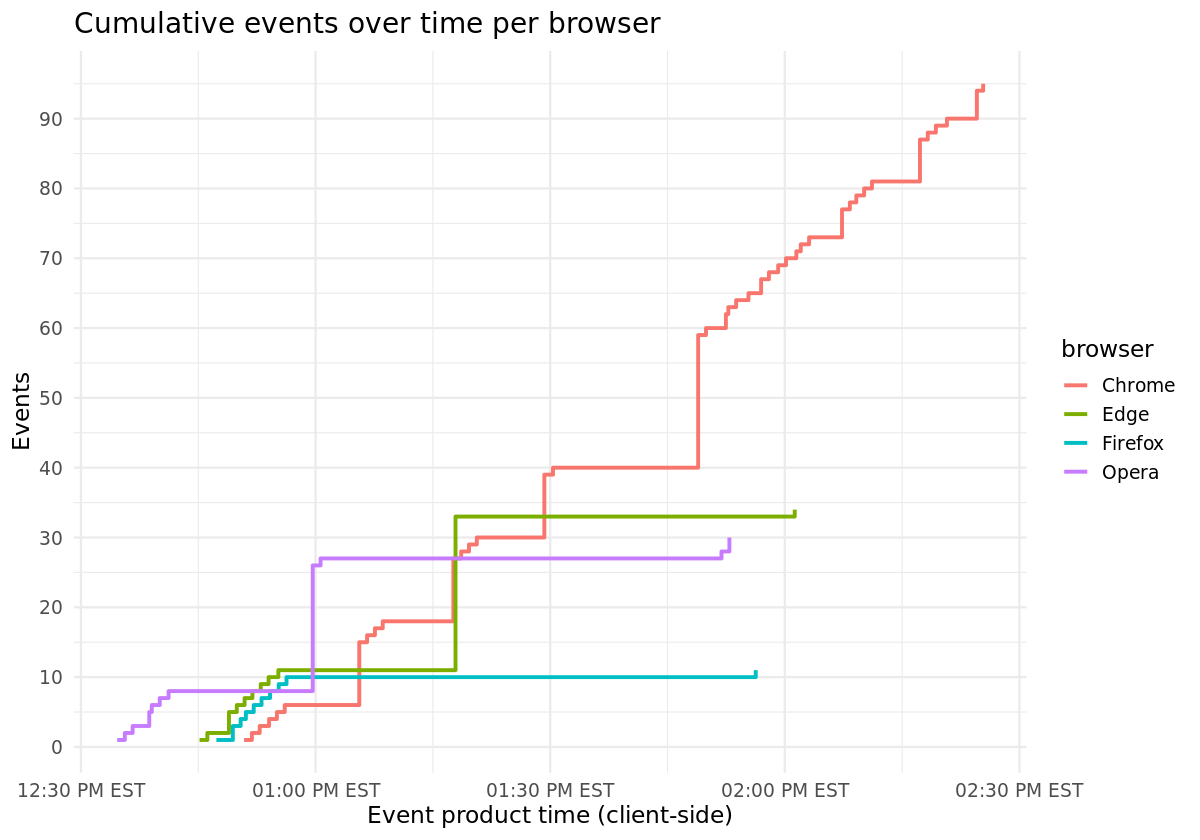

In [5]:
mw_session_ticks %>%
    group_by(browser) %>%
    arrange(dt_client, tick) %>%
    mutate(cumulative_events = cumsum(tick >= 0)) %>%
    ggplot(aes(x = dt_client, y = cumulative_events, color = browser)) +
    geom_step(size = 1.1) +
    scale_y_continuous("Events", breaks = seq(0, 100, 10)) +
    scale_x_datetime(
        "Event product time (client-side)",
        date_labels = "%I:%M %p EST",
        timezone = "America/New_York"
    ) +
    ggtitle("Cumulative events over time per browser")

----

## Session statistics

First, stats we expect to see based on the log:

In [6]:
session_qa <- tribble(
    ~browser, ~n_sessions, ~n_events, ~session_length_longest, ~session_length_shortest,
    "Opera", 2, 30, 26, 2,
    "Edge", 2, 34, 32, 0,
    "Firefox", 2, 11, 9, 0,
    "Chrome", 1, 95, 96, 96
)

session_qa <- session_qa %>%
    mutate(across(where(is.numeric), as.integer)) %>%
    arrange(browser)

session_qa

browser,n_sessions,n_events,session_length_longest,session_length_shortest
<chr>,<int>,<int>,<int>,<int>
Chrome,1,95,96,96
Edge,2,34,32,0
Firefox,2,11,9,0
Opera,2,30,26,2


Then, stats based on the received events:

In [7]:
session_stats <- mw_session_ticks %>%
    group_by(browser) %>%
    arrange(dt_client) %>%
    mutate(session = cumsum(tick == 0)) %>%
    group_by(browser, session) %>%
    summarize(
        n_events = n(),
        length_ticks = max(tick),
        .groups = "drop_last"
    ) %>%
    summarize(
        n_sessions = n(),
        n_events = sum(n_events),
        session_length_longest = max(length_ticks),
        session_length_shortest = min(length_ticks),
        .groups = "drop"
    )

session_stats

browser,n_sessions,n_events,session_length_longest,session_length_shortest
<chr>,<int>,<int>,<int>,<int>
Chrome,1,95,96,96
Edge,2,34,32,0
Firefox,2,11,9,0
Opera,2,30,26,2


## Comparing Expected vs Observed

In [8]:
qa_results <- session_qa %>%
    pivot_longer(where(is.numeric), names_to = "stat", values_to = "expected") %>%
    left_join(
        pivot_longer(session_stats, where(is.numeric), names_to = "stat", values_to = "observed"),
        by = c("browser", "stat")
    ) %>%
    mutate(match = expected == observed)

In [9]:
if (all(qa_results$match)) {
    cat("Passed all checks!")
} else {
    cat("Failed checks:")
    qa_results %>%
        filter(!match) %>%
        select(-match)
}

Passed all checks!